In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      kernel_initializer='he_uniform', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      kernel_initializer='he_uniform')) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same', kernel_initializer='he_uniform'))
        model.add(Activation('relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_20 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_44 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_72 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_73 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_74 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9689 - acc: 0.3819
Epoch 00001: val_loss improved from inf to 1.52503, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_3_conv_checkpoint/001-1.5250.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.9689 - acc: 0.3819 - val_loss: 1.5250 - val_acc: 0.5262
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3567 - acc: 0.5841
Epoch 00002: val_loss improved from 1.52503 to 1.37317, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_3_conv_checkpoint/002-1.3732.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.3568 - acc: 0.5841 - val_loss: 1.3732 - val_acc: 0.5651
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0671 - acc: 0.6751
Epoch 00003: val_loss improved from 1.3

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0693 - acc: 0.9805
Epoch 00029: val_loss did not improve from 1.31726
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0693 - acc: 0.9805 - val_loss: 2.4832 - val_acc: 0.6094
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0666 - acc: 0.9818
Epoch 00030: val_loss did not improve from 1.31726
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0665 - acc: 0.9818 - val_loss: 2.3959 - val_acc: 0.6180
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9813
Epoch 00031: val_loss did not improve from 1.31726
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0687 - acc: 0.9813 - val_loss: 2.3711 - val_acc: 0.6264
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0651 - acc: 0.9828
Epoch 00032: val_loss did not improve from 1.31726
36805/36805 [===========

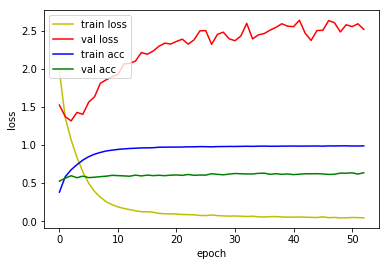

4815/4815 [==============================] - 4s 888us/sample - loss: 1.3940 - acc: 0.5680
Loss: 1.3939541005642615 Accuracy: 0.5680166

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9355 - acc: 0.3811
Epoch 00001: val_loss improved from inf to 1.41609, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_4_conv_checkpoint/001-1.4161.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.9356 - acc: 0.3811 - val_loss: 1.4161 - val_acc: 0.5453
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2938 - acc: 0.5940
Epoch 00002: val_loss improved from 1.41609 to 1.12413, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_4_conv_checkpoint/002-1.1241.hdf5
36805/36805 [==============================] - 86s 2ms/sample - loss: 1.2938 - acc: 0.5940 - val_loss: 1.1241 - val_acc: 0.6520
Epoch 3/500
36800/36805 [======================

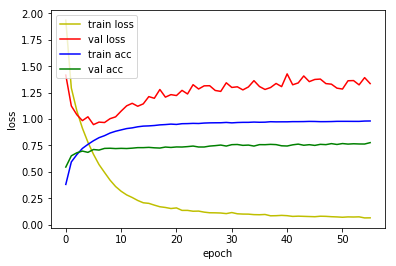

4815/4815 [==============================] - 5s 966us/sample - loss: 1.0441 - acc: 0.6793
Loss: 1.044071129400782 Accuracy: 0.6793354

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8848 - acc: 0.3873
Epoch 00001: val_loss improved from inf to 1.31579, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_5_conv_checkpoint/001-1.3158.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 1.8848 - acc: 0.3873 - val_loss: 1.3158 - val_acc: 0.5868
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2374 - acc: 0.6082
Epoch 00002: val_loss improved from 1.31579 to 1.04575, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_5_conv_checkpoint/002-1.0458.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.2373 - acc: 0.6083 - val_loss: 1.0458 - val_acc: 0.6858
Epoch 3/500
36800/36805 [=======================

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9573
Epoch 00027: val_loss did not improve from 0.69217
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1342 - acc: 0.9573 - val_loss: 0.8554 - val_acc: 0.8123
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1125 - acc: 0.9638
Epoch 00028: val_loss did not improve from 0.69217
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1125 - acc: 0.9638 - val_loss: 0.9246 - val_acc: 0.8039
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1163 - acc: 0.9621
Epoch 00029: val_loss did not improve from 0.69217
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1163 - acc: 0.9621 - val_loss: 0.8733 - val_acc: 0.8143
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1169 - acc: 0.9627
Epoch 00030: val_loss did not improve from 0.69217
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0646 - acc: 0.9810
Epoch 00057: val_loss did not improve from 0.69217
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0646 - acc: 0.9810 - val_loss: 0.8637 - val_acc: 0.8416
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9821
Epoch 00058: val_loss did not improve from 0.69217
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0616 - acc: 0.9821 - val_loss: 0.9150 - val_acc: 0.8325
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0669 - acc: 0.9800
Epoch 00059: val_loss did not improve from 0.69217
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0669 - acc: 0.9800 - val_loss: 0.9149 - val_acc: 0.8360
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0649 - acc: 0.9810
Epoch 00060: val_loss did not improve from 0.69217
36805/36805 [===========

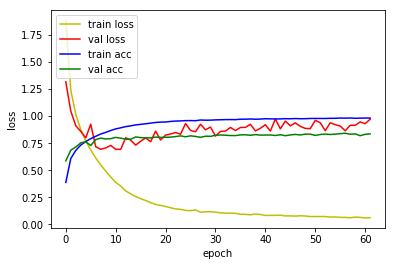

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.7888 - acc: 0.7759
Loss: 0.7887800250469339 Accuracy: 0.7759086

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0580 - acc: 0.3242
Epoch 00001: val_loss improved from inf to 1.51519, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_6_conv_checkpoint/001-1.5152.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 2.0581 - acc: 0.3241 - val_loss: 1.5152 - val_acc: 0.5071
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3639 - acc: 0.5579
Epoch 00002: val_loss improved from 1.51519 to 1.08926, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_6_conv_checkpoint/002-1.0893.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.3638 - acc: 0.5579 - val_loss: 1.0893 - val_acc: 0.6699
Epoch 3/500
36800/36805 [========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1796 - acc: 0.9425
Epoch 00024: val_loss improved from 0.35179 to 0.34246, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_6_conv_checkpoint/024-0.3425.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1797 - acc: 0.9425 - val_loss: 0.3425 - val_acc: 0.9124
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1697 - acc: 0.9458
Epoch 00025: val_loss did not improve from 0.34246
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1696 - acc: 0.9458 - val_loss: 0.3575 - val_acc: 0.9115
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1637 - acc: 0.9467
Epoch 00026: val_loss did not improve from 0.34246
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1637 - acc: 0.9467 - val_loss: 0.3720 - val_acc: 0.9161
Epoch 27/500
36800/36805 [============================>.] - E

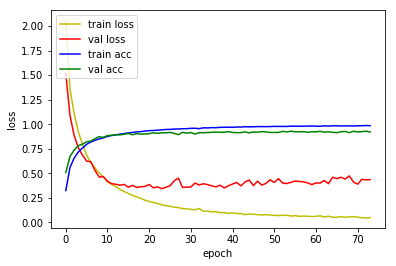

4815/4815 [==============================] - 5s 997us/sample - loss: 0.4060 - acc: 0.8831
Loss: 0.40602451181609805 Accuracy: 0.88307375

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1476 - acc: 0.2886
Epoch 00001: val_loss improved from inf to 1.41290, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_7_conv_checkpoint/001-1.4129.hdf5
36805/36805 [==============================] - 99s 3ms/sample - loss: 2.1475 - acc: 0.2886 - val_loss: 1.4129 - val_acc: 0.5288
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3859 - acc: 0.5471
Epoch 00002: val_loss improved from 1.41290 to 1.01466, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_7_conv_checkpoint/002-1.0147.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.3858 - acc: 0.5471 - val_loss: 1.0147 - val_acc: 0.6904
Epoch 3/500
36800/36805 [====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1672 - acc: 0.9450
Epoch 00024: val_loss did not improve from 0.18861
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1672 - acc: 0.9450 - val_loss: 0.2031 - val_acc: 0.9460
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1597 - acc: 0.9484
Epoch 00025: val_loss did not improve from 0.18861
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1597 - acc: 0.9484 - val_loss: 0.1944 - val_acc: 0.9457
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1516 - acc: 0.9506
Epoch 00026: val_loss improved from 0.18861 to 0.18646, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_7_conv_checkpoint/026-0.1865.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1517 - acc: 0.9506 - val_loss: 0.1865 - val_acc: 0.9471
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9881
Epoch 00082: val_loss did not improve from 0.16892
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0348 - acc: 0.9881 - val_loss: 0.2255 - val_acc: 0.9581
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0422 - acc: 0.9863
Epoch 00083: val_loss did not improve from 0.16892
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0422 - acc: 0.9863 - val_loss: 0.2046 - val_acc: 0.9583
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9885
Epoch 00084: val_loss did not improve from 0.16892
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0337 - acc: 0.9885 - val_loss: 0.2245 - val_acc: 0.9602
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9861
Epoch 00085: val_loss did not improve from 0.16892
36805/36805 [===========

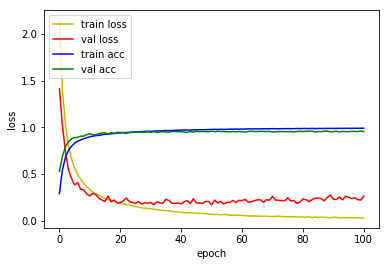

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2113 - acc: 0.9458
Loss: 0.2112701848712155 Accuracy: 0.9457944

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2284 - acc: 0.2723
Epoch 00001: val_loss improved from inf to 1.62077, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_8_conv_checkpoint/001-1.6208.hdf5
36805/36805 [==============================] - 102s 3ms/sample - loss: 2.2284 - acc: 0.2724 - val_loss: 1.6208 - val_acc: 0.4838
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2999 - acc: 0.5728
Epoch 00002: val_loss improved from 1.62077 to 0.80439, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_8_conv_checkpoint/002-0.8044.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.2999 - acc: 0.5728 - val_loss: 0.8044 - val_acc: 0.7452
Epoch 3/500
36800/36805 [=======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.1373 - acc: 0.9548
Epoch 00024: val_loss did not improve from 0.13708
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1376 - acc: 0.9548 - val_loss: 0.1407 - val_acc: 0.9548
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9538
Epoch 00025: val_loss improved from 0.13708 to 0.12503, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_8_conv_checkpoint/025-0.1250.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1424 - acc: 0.9538 - val_loss: 0.1250 - val_acc: 0.9655
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1189 - acc: 0.9613
Epoch 00026: val_loss did not improve from 0.12503
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1189 - acc: 0.9613 - val_loss: 0.1395 - val_acc: 0.9623
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9826
Epoch 00053: val_loss did not improve from 0.12178
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0518 - acc: 0.9826 - val_loss: 0.1372 - val_acc: 0.9641
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9829
Epoch 00054: val_loss did not improve from 0.12178
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0514 - acc: 0.9829 - val_loss: 0.1330 - val_acc: 0.9634
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0515 - acc: 0.9827
Epoch 00055: val_loss improved from 0.12178 to 0.12045, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_8_conv_checkpoint/055-0.1204.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0515 - acc: 0.9827 - val_loss: 0.1204 - val_acc: 0.9686
Epoch 56/500
36800/36805 [============================>.] - E

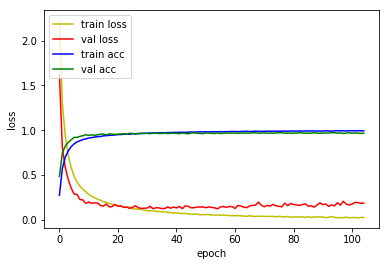

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1693 - acc: 0.9593
Loss: 0.16933327621576277 Accuracy: 0.9592939

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7783 - acc: 0.4233
Epoch 00001: val_loss improved from inf to 0.82010, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_9_conv_checkpoint/001-0.8201.hdf5
36805/36805 [==============================] - 106s 3ms/sample - loss: 1.7783 - acc: 0.4233 - val_loss: 0.8201 - val_acc: 0.7428
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8247 - acc: 0.7331
Epoch 00002: val_loss improved from 0.82010 to 0.46015, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_he-uniform_DO_9_conv_checkpoint/002-0.4602.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.8247 - acc: 0.7331 - val_loss: 0.4602 - val_acc: 0.8530
Epoch 3/500
36800/36805 [======================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9736
Epoch 00025: val_loss did not improve from 0.12524
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0784 - acc: 0.9736 - val_loss: 0.1351 - val_acc: 0.9627
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0733 - acc: 0.9757
Epoch 00026: val_loss did not improve from 0.12524
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0733 - acc: 0.9757 - val_loss: 0.1353 - val_acc: 0.9634
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0718 - acc: 0.9759
Epoch 00027: val_loss did not improve from 0.12524
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0718 - acc: 0.9759 - val_loss: 0.1363 - val_acc: 0.9630
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0653 - acc: 0.9783
Epoch 00028: val_loss did not improve from 0.12524
36805/36805 [===========


1D_CNN_custom_conv_3_VGG_he-uniform_DO_9_conv Model


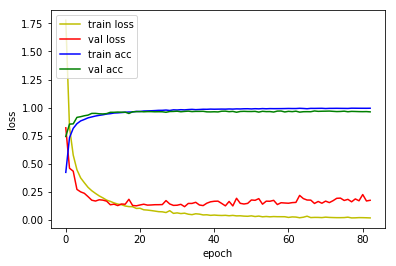

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1830 - acc: 0.9533
Loss: 0.18304576338853915 Accuracy: 0.95327103



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_conv_3_VGG_he-uniform_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_he-uniform_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_he-uniform_DO_3_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)      

4815/4815 [==============================] - 4s 924us/sample - loss: 0.7888 - acc: 0.7759
Loss: 0.7887800250469339 Accuracy: 0.7759086

1D_CNN_custom_conv_3_VGG_he-uniform_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_114 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_115 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_116 (Acti

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2113 - acc: 0.9458
Loss: 0.2112701848712155 Accuracy: 0.9457944

1D_CNN_custom_conv_3_VGG_he-uniform_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_140 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_141 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_142 (Activa

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1830 - acc: 0.9533
Loss: 0.18304576338853915 Accuracy: 0.95327103


In [13]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_he-uniform_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
activation_90 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_91 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_92 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
activation_92 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_93 (Conv1D)     

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.1940 - acc: 0.7996
Loss: 1.1940153389085986 Accuracy: 0.7995846

1D_CNN_custom_conv_3_VGG_he-uniform_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_114 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_115 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_116 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_116 (Activa

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2778 - acc: 0.9468
Loss: 0.2778356967471588 Accuracy: 0.94683284

1D_CNN_custom_conv_3_VGG_he-uniform_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
activation_140 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_141 (Activation)  (None, 16000, 64)         0         
_________________________________________________________________
conv1d_142 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
activation_142 (Activ

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2779 - acc: 0.9462
Loss: 0.27794505369521655 Accuracy: 0.9462098
